In [16]:
import glob
import os
import warnings
warnings.filterwarnings("ignore")

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import xarray as xr

from esem import gp_model
from esem.utils import get_random_params
from esem.utils import leave_one_out, prediction_within_ci
from esem.sampler import MCMCSampler
from scipy import stats
import gpflow

from SALib.sample import fast_sampler
from SALib.analyze import fast

### Explore parameter senstivity 

- Use Gaussian process emulator to explore one-at-a-time parameter influence
    - ESEm: https://esem.readthedocs.io/en/latest/index.html
    - Introduction to GP emulation: https://distill.pub/2019/visual-exploration-gaussian-processes/



Determine relative parameter influence using Fourier transform variance decomposition

In [3]:
#read in LAI metrics
ds = xr.open_dataset('./processed_data/metrics/TLAI.nc')

In [4]:
# get parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
ppe_params = df.drop(columns='member')
num_params = len(ppe_params.columns)

In [5]:
# select target variable and divide LHC dataset into training and testing subsets
var = 'TLAI_global_avg_2010'
n_test = 50 # number of ensemble members to test emulator
Y = ds[var][1:].values # target variable excluding default model [0]
default = ds[var][0].values # default model value

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
y_test, y_train = Y[:n_test], Y[n_test:]

In [6]:
# define kernal
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(5,num_params))
#kernel_poly = gpflow.kernels.Polynomial(active_dims=range(num_params),variance=3,offset=0)

kernel = kernel_linear + kernel_matern32
kernel

2022-12-05 11:20:59.780124: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-05 11:20:59.780176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc52): /proc/driver/nvidia/version does not exist
2022-12-05 11:20:59.785601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
Sum.kernels[1].lengthscales,Parameter,Softplus,,True,"(32,)",float64,"[1., 1., 1...."


In [7]:
# define emulator model and train
emulator = gp_model(np.array(X_train),np.array(y_train),kernel = kernel)
emulator.train()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
# Predict test points with emulator
y_pred, y_pred_var = emulator.predict(X_test.values)

Root Mean Square Error =  0.17602399014901013


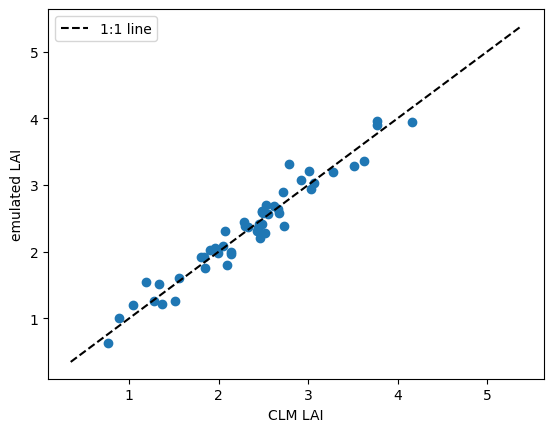

In [9]:
# plot predicted values
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(y_test, y_pred, squared=False)
print('Root Mean Square Error = ', rms)

plt.scatter(y_test,y_pred)
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)],c='k',linestyle='--',label='1:1 line')
plt.xlabel('CLM LAI')
plt.ylabel('emulated LAI')
plt.legend()

In [13]:
# Oone-at-a-time sensitivity 
n=21
s = np.linspace(0,1,n)
unif = pd.concat([pd.DataFrame(np.tile(0.5,n))]*num_params,axis=1) # hold all parameters at median value
unif.columns = ppe_params.columns
#unif['leafcn'] = np.tile(0.8,n) # change individual parameter default setting for OAAT

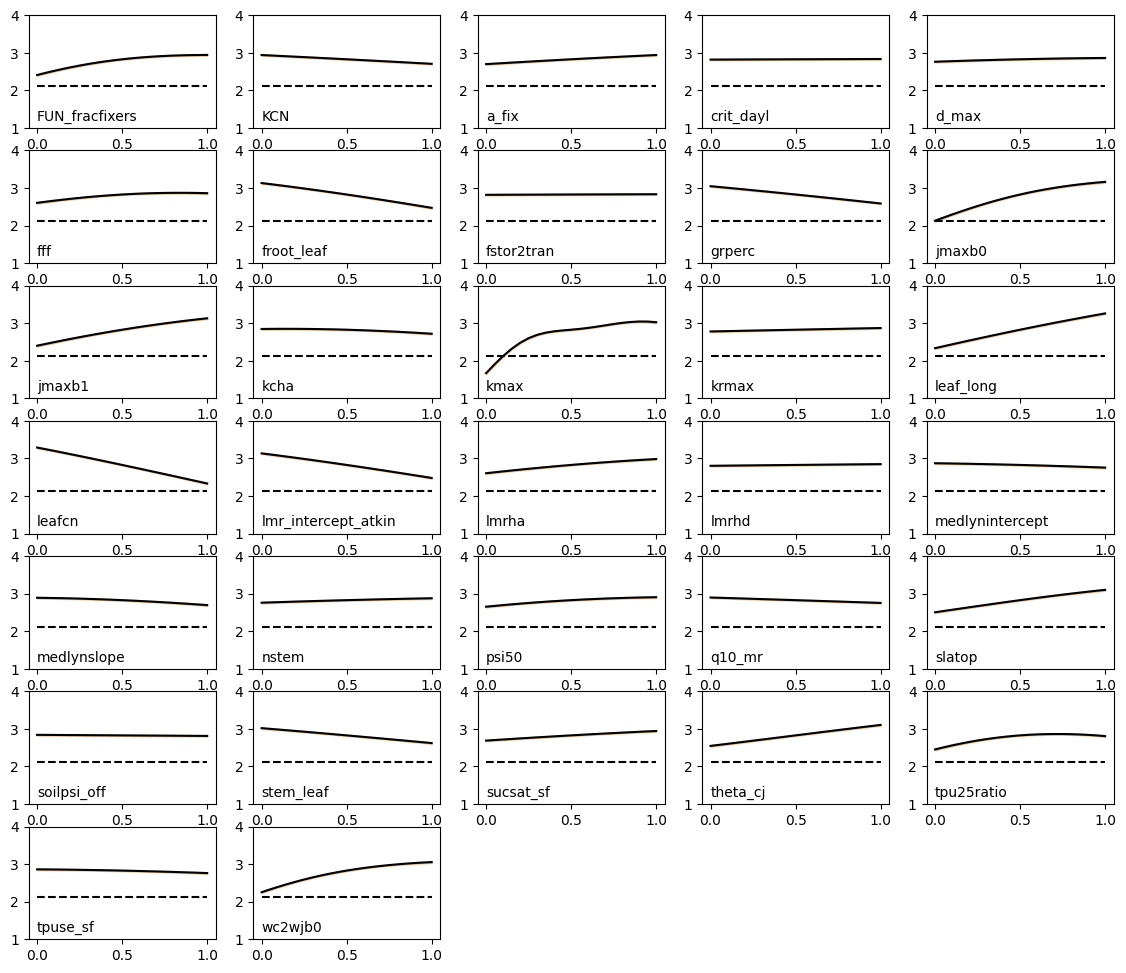

In [14]:
plt.figure(figsize=[14,12])
sample = unif
for i, p in enumerate(ppe_params.columns):
    
    sample[p] = s
    oaat, sd = emulator.predict(sample)
    sample[p] = np.tile(0.5,n) # set column back to median
    
    ax=plt.subplot(7,5,i+1)
    ax.fill_between(s, oaat-3.0*sd, oaat+3.0*sd,color='peru',alpha=0.4) # shade three standard deviations
    ax.plot(s,oaat,c='k')
    plt.text(0,1.2,p)
    plt.plot([0,1],[default, default],'--',c='k')
    ax.set_ylim([1,4])
    
plt.savefig('OAAT_sensitivity_GM-AM_TLAI.png',dpi=200)

In [15]:
# fourier amplitude sensitivity test
problem = {
    'names': ppe_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}
problem

{'names': Index(['FUN_fracfixers', 'KCN', 'a_fix', 'crit_dayl', 'd_max', 'fff',
        'froot_leaf', 'fstor2tran', 'grperc', 'jmaxb0', 'jmaxb1', 'kcha',
        'kmax', 'krmax', 'leaf_long', 'leafcn', 'lmr_intercept_atkin', 'lmrha',
        'lmrhd', 'medlynintercept', 'medlynslope', 'nstem', 'psi50', 'q10_mr',
        'slatop', 'soilpsi_off', 'stem_leaf', 'sucsat_sf', 'theta_cj',
        'tpu25ratio', 'tpuse_sf', 'wc2wjb0'],
       dtype='object'),
 'num_vars': 32,
 'bounds': [[0, 1]]}

In [27]:
sample = fast_sampler.sample(problem, 1000, M=4, seed=None)
Y, _ = emulator.predict(sample)
FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95, print_to_console=False, seed=None)
df_sens = pd.DataFrame.from_dict(FAST)
df_sens.index = df_sens.names
df_sens = df_sens.sort_values(by=['S1'],ascending=False)

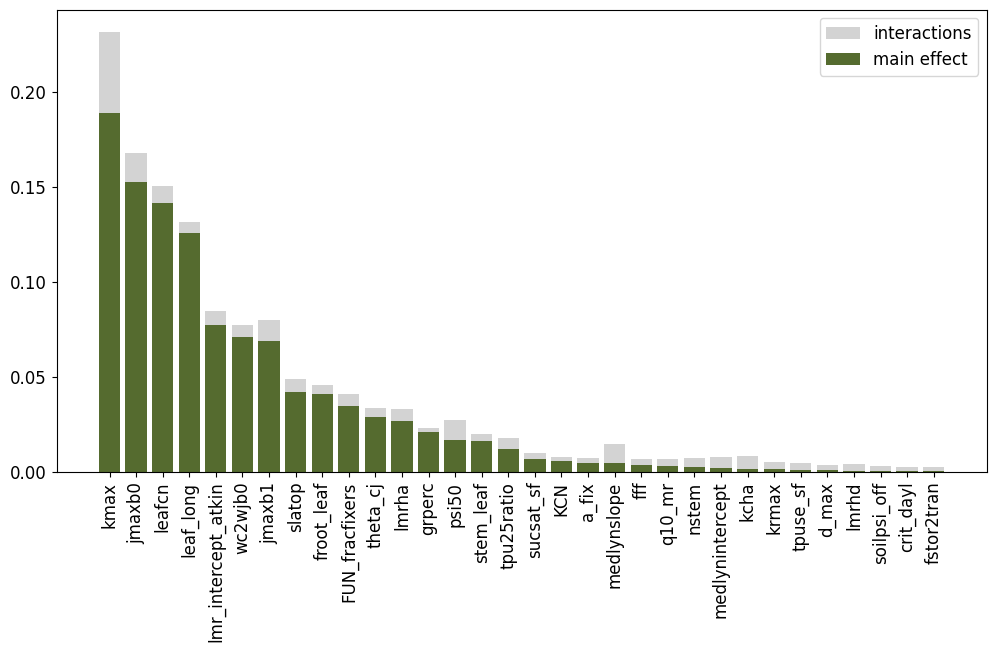

In [32]:
plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

#df_sens.plot.bar(x='names', y='S1', rot=45)
ax = plt.subplot(1,1,1)
ax.bar(df_sens.names,df_sens['ST'],color='lightgrey',label='interactions')
ax.bar(df_sens.names,df_sens['S1'],color='darkolivegreen',label='main effect')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')